In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage
import os
import cv2
from tqdm import tqdm
from utils import get_2D_projections
from datetime import datetime
import traceback
from PIL import Image

%env SITK_SHOW_COMMAND 'C:\ProgramData\slicer.org\Slicer 5.4.0\Slicer'

env: SITK_SHOW_COMMAND='C:\ProgramData\slicer.org\Slicer 5.4.0\Slicer'


In [2]:
import sys

parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from Utils import utils

In [3]:
config = utils.read_config()
config

{'common': {'paths': {'source_path_wd': 'E:/U-CAN-Lymfom_A',
   'source_path_bd': '/media/andres/T7 Shield/ucan_lymfom'}},
 'selection': {'filenames': {'rejected_folder_filename': 'Rejected_exams_from_U-CAN-Lymfom.xlsx',
   'sourcefiltered_folder_filename': 'SourceFiltered_exams_from_U-CAN-Lymfom.xlsx',
   'incomplete_folders_filename_initial': 'Excel_files/06_11_2023/No_PT_or_CT_exams_from_U-CAN-Lymfom_before_selection_process.xlsx',
   'incomplete_folders_filename_final': 'Excel_files/06_11_2023/No_PT_or_CT_exams_from_U-CAN-Lymfom_after_selection_process.xlsx',
   'selected_folders_beforefiltering_filename': 'Excel_files/06_11_2023/Selected_exams_after_filtering_from_U-CAN-Lymfom.xlsx',
   'selected_folders_afterfiltering_filename': 'Excel_files/06_11_2023/Selected_exams_before_filtering_from_U-CAN-Lymfom.xlsx',
   'final_selected_images_filename': 'Excel_files/06_11_2023/Final_Selected_exams_from_U-CAN-Lymfom.xlsx',
   'list_of_distorted_images_filename': 'Excel_files/06_11_2023/exa

In [4]:
source_path_wd = config['common']['paths']['source_path_wd']
source_path_bd = config['common']['paths']['source_path_bd']
final_selected_images_filename = config['metadata']['filenames']['final_selected_images_filename']
#projection_path = 'E:\\Sambit\\Project_10\\Data\\2D Projections\\' #config['projections']['paths']['destination_path']
projection_path = 'G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/'

selection_dataframe = os.path.join(source_path_wd, final_selected_images_filename)
final_projections = os.path.join(source_path_wd, projection_path)
final_projections

'G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/'

In [5]:
selection_dataframe

'E:/U-CAN-Lymfom_A\\Excel_files/06_11_2023/Finalized_dataset.xlsx'

In [6]:
projections = config['projections']
projections

{'paths': {'destination_path': 'Selected_for_UCAN_project/2dprojections'},
 'variables': {'modality': ['CT', 'PT', 'SUV'],
  'tissue_type': ['LT', 'AT', 'LT', 'B', 'N'],
  'projection_type': ['sum', 'min', 'max', 'mean', 'std'],
  'angles': [0, 90]}}

In [7]:
modality = projections['variables']['modality']
ttype = projections['variables']['tissue_type'][:-1]
ptype = projections['variables']['projection_type']
angles = projections['variables']['angles']

In [8]:
ttype

['LT', 'AT', 'LT', 'B']

In [9]:
config_size = config['resampling']['image_size']
config_spacing = config['resampling']['voxel_spacing']
print('config_size: ', config_size)
print('config_spacing: ', config_spacing)

config_size:  [256, 256, 256]
config_spacing:  [2.0364201068878174, 2.0364201068878174, 3.0]


In [10]:
#resampled_destination_path = 'E:/Sambit/Other_Projects/UCAN/Resampled_SUV_CT/'
#resampled_destination_path = 'E:/Sambit/Project_10/Data/Resampled_SUV_CT/'
#resampled_destination_path = 'G:/UCAN_project/'
#resampled_destination_path = 'F:/ucan_lymfom/Resampled_SUV_CT/Sample31Oct2023/'
resampled_destination_path = 'G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023'

In [11]:
twodp_list = []

for dirs, subdirs, files in os.walk(resampled_destination_path):
    for file in files:
        file_path = str(os.path.join(dirs, file))
        file_path = file_path.replace('\\','/')
        twodp_list.append(file_path)
        print(file_path)

G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450/20130412/CT_MIP/-90.0.png
G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450/20130412/CT_MIP/-90.0.npy
G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450/20130412/CT_MIP/0.0.png
G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450/20130412/CT_MIP/0.0.npy
G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450/20130412/CT_MIP/90.0.png
G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450/20130412/CT_MIP/90.0.npy
G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450/20130412/CT_bone/-90.0.png
G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450/20130412/CT_bone/-90.0.npy
G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450/20130412/CT_bone/0.0.png
G:/U-C

In [12]:
twodp_df = pd.DataFrame(twodp_list, columns=['directory'])
twodp_df[['source_directory', 'examination', 'type', 'projection']] = twodp_df['directory'].str.rsplit(pat='/', n=3, expand=True)
twodp_df = twodp_df[ np.logical_or(twodp_df['projection'] == '0.0.png',twodp_df['projection'] == '-90.0.png') ] #selecting only 0 and -90 projections
twodp_df['patid'] = [ i.split('/')[-1] for i in twodp_df['source_directory'] ] #twodp_df['source_directory'].str.rsplit('/')[-1]
twodp_df = twodp_df.reindex(columns=[ 'directory', 'source_directory', 'patid', 'examination', 'type', 'projection'
       ],)
# twodp_df.drop(columns=['directory','extra', 'SUV_CT'], inplace=True)
twodp_df = twodp_df.reset_index(drop=True)
utils.display_full(twodp_df.head(50))


                                                                                                              directory                                                                      source_directory            patid examination         type projection
0        G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450/20130412/CT_MIP/-90.0.png  G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450  npr100169878450    20130412       CT_MIP  -90.0.png
1          G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450/20130412/CT_MIP/0.0.png  G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450  npr100169878450    20130412       CT_MIP    0.0.png
2       G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450/20130412/CT_bone/-90.0.png  G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450  npr100169878450 

In [14]:
for exa in twodp_df.examination:
    exa_df = twodp_df[twodp_df['examination']==exa]
    for type in exa_df.type:
        type_df = exa_df[exa_df['type']==type].reset_index(drop=True)
        img_c = type_df.directory[0]
        img_s = type_df.directory[1]
        save_path = type_df.source_directory[0] + '/' + type_df.examination[0] + '/' + type_df.type[0] + '/' + f'{type_df.examination[0]}.png'
        utils.create_collage(img_c,img_s,save_path)
        print('Collage: ',save_path, ' successfully saved!', end='\n')
        

    





Collage:  G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450/20130412/CT_MIP/20130412.png  successfully saved!
Collage:  G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450/20130412/CT_MIP/20130412.png  successfully saved!
Collage:  G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450/20130412/CT_bone/20130412.png  successfully saved!
Collage:  G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450/20130412/CT_bone/20130412.png  successfully saved!
Collage:  G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450/20130412/CT_lean/20130412.png  successfully saved!
Collage:  G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450/20130412/CT_lean/20130412.png  successfully saved!
Collage:  G:/U-CAN-Lymfom_A/Projections/2DProjections_ResampledImages_8Nov2023/npr100169878450/20130412/CT_adipose/20130412.pn

### Testing projections

folder structure: patient / scandate / CT_tissuetype/angle.npy

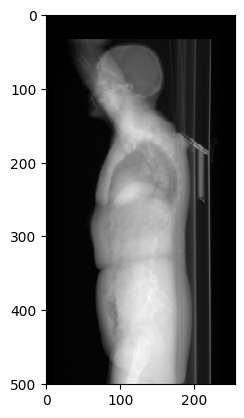

In [7]:
file_path = r'g:\U-CAN-Lymfom_A\Projections\2DProjections_ResampledImages_8Nov2023\npr104155030926\20200612\CT_MIP\0.0.npy'
temp = np.load(file_path)
plt.imshow(temp, cmap="gray")

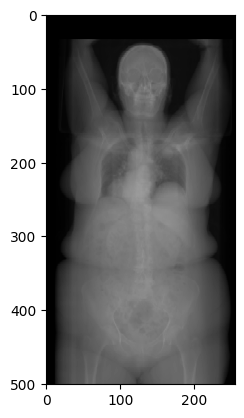

In [5]:
file_path = r'g:\U-CAN-Lymfom_A\Projections\2DProjections_ResampledImages_8Nov2023\npr104155030926\20200612\CT_MIP\90.0.npy'
temp = np.load(file_path)
plt.imshow(temp, cmap="gray")